<a href="https://colab.research.google.com/github/maria-papz/final-year-project/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification Model Training and evaluation

## LSTM model with GloVe Embeddings


In [ ]:
import pandas as pd
# Define column names
column_names = ['Sentiment', 'Text']
df = pd.read_csv('financialPhraseBank.csv',names=column_names, encoding='ISO-8859-1')
df.head()

,Sentiment,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


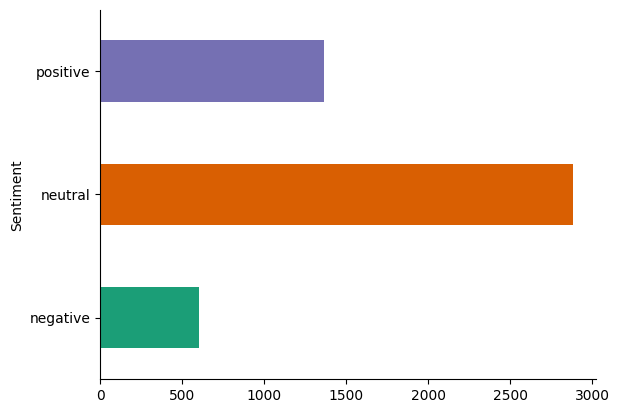

In [ ]:

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#  preprocessing function
def preprocess_text(df):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    # punctuation and emoji removal and lowercasing
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))
    df['Text'] = df['Text'].apply(lambda x: x.lower())

    # tokenization
    df['Text'] = df['Text'].apply(lambda x: nltk.word_tokenize(str(x)))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df['Text'] = df['Text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return df


In [ ]:
train_df = preprocess_text(train_df.copy())
test_df = preprocess_text(test_df.copy())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Tokenization and sequence padding
tokeniser = Tokenizer(num_words=10000)
tokeniser.fit_on_texts(train_df['Text'])

train_sequences = tokeniser.texts_to_sequences(train_df['Text'])
test_sequences = tokeniser.texts_to_sequences(test_df['Text'])

# Determine the maximum sequence length based on training data
max_sequence_length = max([len(seq) for seq in train_sequences])

# Padding sequences
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Update 'Text' column with padded sequences
train_df['Text'] = list(train_padded_sequences)
test_df['Text'] = list(test_padded_sequences)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np


# Convert the 'Sentiment' labels into integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(train_df['Sentiment'])

# Convert integers to one hot encoded
onehot_encoded = to_categorical(integer_encoded)


trainX = np.array(train_df['Text'].tolist())
trainy = onehot_encoded


In [ ]:
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index



In [ ]:
glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')
embedding_dim = 100  # Assuming we're using GloVe embeddings with 100 dimensions
vocab_size = len(tokeniser.word_index) + 1  # Plus 1 for padding token

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokeniser.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length,
                    weights=[embedding_matrix],
                    trainable=True))  # Set trainable to True to fine-tune the embeddings

lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 100)           911600    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 47, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 992303 (3.79 MB)
Trainable params: 992303 (3.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    min_delta=0.001,  # Minimum change to qualify as an improvement
    patience=20,  # How many epochs to wait before stopping
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
)
history = lstm_model.fit(
    train_padded_sequences, trainy,
    epochs=100,  # Set to a large value; early stopping will halt training when improvement stops
    batch_size=16,
    validation_split=0.1,  # Alternatively, use validation_data=(valX, valY)
    callbacks=[early_stopping],  # Include early stopping
    verbose=1
)

Epoch 1/100
218/218 [==============================] - 10s 35ms/step - loss: 0.8186 - accuracy: 0.6408 - val_loss: 0.7268 - val_accuracy: 0.6443
Epoch 2/100
218/218 [==============================] - 7s 31ms/step - loss: 0.6639 - accuracy: 0.7079 - val_loss: 0.7086 - val_accuracy: 0.6856
Epoch 3/100
218/218 [==============================] - 7s 33ms/step - loss: 0.5261 - accuracy: 0.7784 - val_loss: 0.6833 - val_accuracy: 0.7165
Epoch 4/100
218/218 [==============================] - 7s 31ms/step - loss: 0.4068 - accuracy: 0.8323 - val_loss: 0.7385 - val_accuracy: 0.6985
Epoch 5/100
218/218 [==============================] - 7s 32ms/step - loss: 0.2917 - accuracy: 0.8827 - val_loss: 0.7639 - val_accuracy: 0.7242
Epoch 6/100
218/218 [==============================] - 9s 39ms/step - loss: 0.2240 - accuracy: 0.9134 - val_loss: 0.7941 - val_accuracy: 0.7165
Epoch 7/100
218/218 [==============================] - 8s 35ms/step - loss: 0.1686 - accuracy: 0.9366 - val_loss: 0.8733 - val_accuracy

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(test_df['Sentiment'])

# Convert integers to one hot encoded
onehot_encoded = to_categorical(integer_encoded)
testX = np.array(test_df['Text'].tolist())  # Assuming 'Text' column contains the padded sequences
testy = onehot_encoded
test_predictions = lstm_model.predict(test_padded_sequences)


31/31 [==============================] - 0s 10ms/step


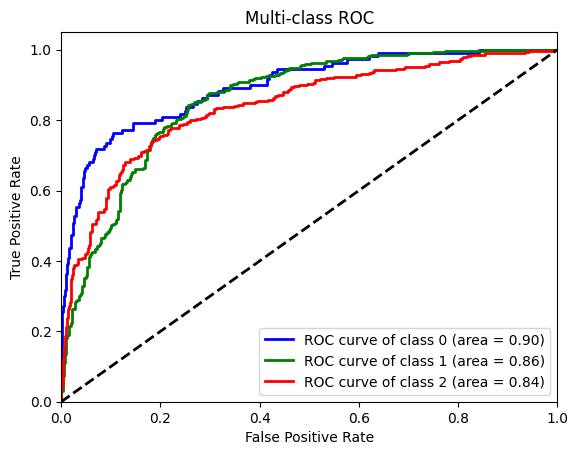

In [ ]:
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(testy, axis=1)  # Assuming testy is also one-hot encoded
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels if they aren't already
n_classes = 3  # Assuming 3 classes: negative, positive, neutral
true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2])  # Adjust classes as needed

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


Accuracy: 74.43%


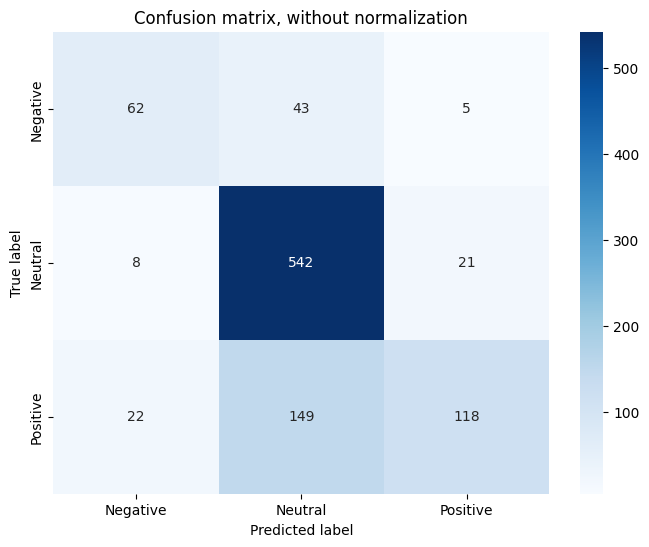

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy*100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Negative',  'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion matrix, without normalization')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Fine-Tuning FinBERT Model

In [ ]:
def tokens_to_string(token_list):
    """
    Converts a list of tokens back into a string.
    """
    return ' '.join(token_list)


from sklearn.model_selection import train_test_split

# Split data into training+validation and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42) # 0.1 x 0.8 = 0.08

# train_df = preprocess_text(train_df.copy())
# val_df = preprocess_text(train_df.copy())
# test_df = preprocess_text(test_df.copy())

# train_df['Text'] = train_df['Text'].apply(tokens_to_string)
# val_df['Text'] = val_df['Text'].apply(tokens_to_string)
# test_df['Text'] = test_df['Text'].apply(tokens_to_string)


In [ ]:
from transformers import BertTokenizer


# Initialise the tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone', do_lower_case=True)

# Tokenise all the texts and find the max length
all_texts = pd.concat([train_df['Text'], val_df['Text'], test_df['Text']])
tokenized_texts = [tokenizer.tokenize(text) for text in all_texts]
max_length = max([len(text) for text in tokenized_texts])
print("Max length for padding:", max_length)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

Max length for padding: 132


In [ ]:
def encode_data(tokenizer, texts, max_length):
    return tokenizer.batch_encode_plus(
        texts,
        return_tensors='pt',
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_length,
        truncation=True
    )



In [ ]:
encoded_data_train = encode_data(tokenizer, train_df['Text'].values, max_length)
encoded_data_val = encode_data(tokenizer, val_df['Text'].values, max_length)
encoded_data_test = encode_data(tokenizer, test_df['Text'].values, max_length)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape your data and fit the encoder
sentiment_labels = df['Sentiment'].values.reshape(-1, 1)
encoder.fit(sentiment_labels)


train_labels_onehot = encoder.transform(train_df['Sentiment'].values.reshape(-1, 1))
val_labels_onehot = encoder.transform(val_df['Sentiment'].values.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_df['Sentiment'].values.reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

dataset_train = TensorDataset(
    encoded_data_train['input_ids'],
    encoded_data_train['attention_mask'],
    torch.tensor(train_labels_onehot, dtype=torch.float)
)

dataset_val = TensorDataset(
    encoded_data_val['input_ids'],
    encoded_data_val['attention_mask'],
    torch.tensor(val_labels_onehot, dtype=torch.float)
)

dataset_test = TensorDataset(
    encoded_data_test['input_ids'],
    encoded_data_test['attention_mask'],
    torch.tensor(test_labels_onehot, dtype=torch.float)
)


In [ ]:
import torch

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Model setup
bert_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False)
optimizer = AdamW(bert_model.parameters(), lr=1e-5, eps=1e-8)

# DataLoader setup
batch_size = 16
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

# Early stopping setup
patience = 3
best_val_loss = float("inf")
no_improvement = 0
bert_model.to(device)

for epoch in range(1, 6 + 1):
    bert_model.train()
    for batch in dataloader_train:
        batch = tuple(item.to(device) for item in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        bert_model.zero_grad()
        outputs = bert_model(**inputs)  # Pass unpacked inputs as named arguments
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        optimizer.step()


 # Validation steps
    bert_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader_validation:
            batch = tuple(item.to(device) for item in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }
            outputs = bert_model(**inputs)
            loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(dataloader_validation)
    print(f"Epoch {epoch} | Validation Loss: {val_loss}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(bert_model.state_dict(), "best_model_state1.bin")  # Save best model state
    else:
        no_improvement += 1
        if no_improvement == patience:
            print("Early stopping triggered")
            break


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Validation Loss: 0.30556002877652644
Epoch 2 | Validation Loss: 0.22429353713989258
Epoch 3 | Validation Loss: 0.2634125480242073
Epoch 4 | Validation Loss: 0.36165558821870947
Epoch 5 | Validation Loss: 0.48404504482925403
Early stopping triggered


In [ ]:

import torch
from torch.utils.data import DataLoader, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

from transformers import BertForSequenceClassification, BertConfig
import torch


dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=batch_size)

# Path to your saved model weights
model_path = 'best_model_state1.bin'


config = BertConfig.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)  # Adjust as needed
bert_model = BertForSequenceClassification(config)

# Load the state dict from the file
bert_model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to the appropriate device and set it to evaluation mode
bert_model.to(device)
bert_model.eval()

bert_model.to(device) # Move model to the appropriate device

# Lists to hold predictions and true labels
true_labels = []
predictions = []

# Predict
with torch.no_grad():
    for batch in dataloader_test:
        batch = tuple(item.to(device) for item in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

        outputs = bert_model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

        predictions.append(probs.cpu().numpy())
        true_labels.append(batch[2].cpu().numpy())

# Concatenate the results across the batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)



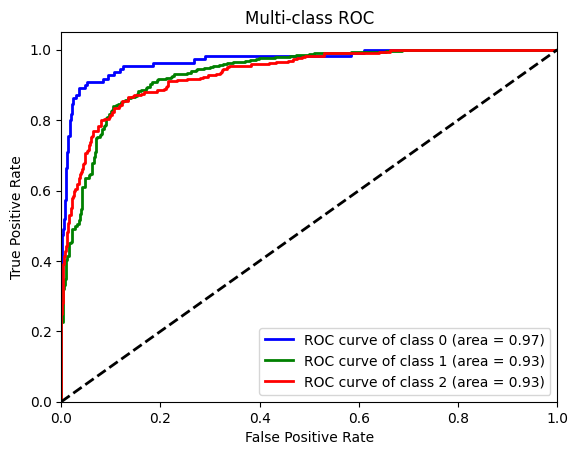

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels if they aren't already
n_classes = 3  # Assuming 3 classes: negative, positive, neutral
true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.8525773195876288


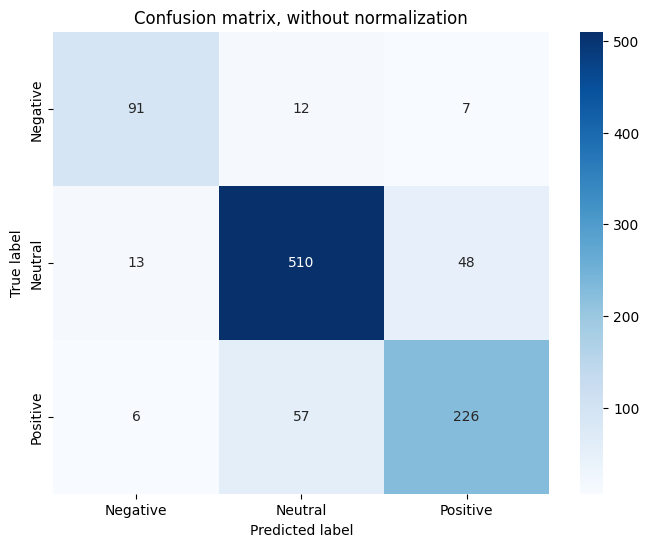

In [ ]:
# Calculate accuracy
if len(true_labels.shape) > 1 and true_labels.shape[1] > 1:  # Check if `true_labels` is one-hot encoded
    true_labels = np.argmax(true_labels, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Negative',  'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion matrix, without normalization')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Fine-Tuning BERT model

In [ ]:
from transformers import BertTokenizer


# Initialise the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenise all the texts and find the max length
all_texts = pd.concat([train_df['Text'], val_df['Text'], test_df['Text']])
tokenized_texts = [tokenizer.tokenize(text) for text in all_texts]
max_length = max([len(text) for text in tokenized_texts])
print("Max length for padding:", max_length)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Max length for padding: 148


In [ ]:
def encode_data(tokenizer, texts, max_length):
    return tokenizer.batch_encode_plus(
        texts,
        return_tensors='pt',
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_length,
        truncation=True
    )



In [ ]:
encoded_data_train = encode_data(tokenizer, train_df['Text'].values, max_length)
encoded_data_val = encode_data(tokenizer, val_df['Text'].values, max_length)
encoded_data_test = encode_data(tokenizer, test_df['Text'].values, max_length)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape your data and fit the encoder
sentiment_labels = df['Sentiment'].values.reshape(-1, 1)
encoder.fit(sentiment_labels)


train_labels_onehot = encoder.transform(train_df['Sentiment'].values.reshape(-1, 1))
val_labels_onehot = encoder.transform(val_df['Sentiment'].values.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_df['Sentiment'].values.reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

dataset_train = TensorDataset(
    encoded_data_train['input_ids'],
    encoded_data_train['attention_mask'],
    torch.tensor(train_labels_onehot, dtype=torch.float)
)

dataset_val = TensorDataset(
    encoded_data_val['input_ids'],
    encoded_data_val['attention_mask'],
    torch.tensor(val_labels_onehot, dtype=torch.float)
)

dataset_test = TensorDataset(
    encoded_data_test['input_ids'],
    encoded_data_test['attention_mask'],
    torch.tensor(test_labels_onehot, dtype=torch.float)
)


In [ ]:
import torch

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")


Using device: cuda


In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Model setup
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False)
optimizer = AdamW(bert_model.parameters(), lr=1e-5, eps=1e-8)

# DataLoader setup
batch_size = 16
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

# Early stopping setup
patience = 3
best_val_loss = float("inf")
no_improvement = 0
bert_model.to(device)

for epoch in range(1, 6 + 1):
    bert_model.train()
    for batch in dataloader_train:
        batch = tuple(item.to(device) for item in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        bert_model.zero_grad()
        outputs = bert_model(**inputs)  # Pass unpacked inputs as named arguments
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        optimizer.step()


 # Validation steps
    bert_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader_validation:
            batch = tuple(item.to(device) for item in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }
            outputs = bert_model(**inputs)
            loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(dataloader_validation)
    print(f"Epoch {epoch} | Validation Loss: {val_loss}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(bert_model.state_dict(), "best_model_state2.bin")  # Save best model state
    else:
        no_improvement += 1
        if no_improvement == patience:
            print("Early stopping triggered")
            break


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Validation Loss: 0.40302644431591034
Epoch 2 | Validation Loss: 0.27006508737802504
Epoch 3 | Validation Loss: 0.22330519288778305
Epoch 4 | Validation Loss: 0.23653228901326656
Epoch 5 | Validation Loss: 0.2492202091962099
Epoch 6 | Validation Loss: 0.2915509887225926
Early stopping triggered


In [ ]:

import torch
from torch.utils.data import DataLoader, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

from transformers import BertForSequenceClassification, BertConfig
import torch


dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=batch_size)

# Path to your saved model weights
model_path = 'best_model_state2.bin'


config = BertConfig.from_pretrained('bert-base-uncased', num_labels=3)  # Adjust as needed
bert_model = BertForSequenceClassification(config)

# Load the state dict from the file
bert_model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to the appropriate device and set it to evaluation mode
bert_model.to(device)
bert_model.eval()

bert_model.to(device) # Move model to the appropriate device

# Lists to hold predictions and true labels
true_labels = []
predictions = []

# Predict
with torch.no_grad():
    for batch in dataloader_test:
        batch = tuple(item.to(device) for item in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

        outputs = bert_model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

        predictions.append(probs.cpu().numpy())
        true_labels.append(batch[2].cpu().numpy())

# Concatenate the results across the batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)



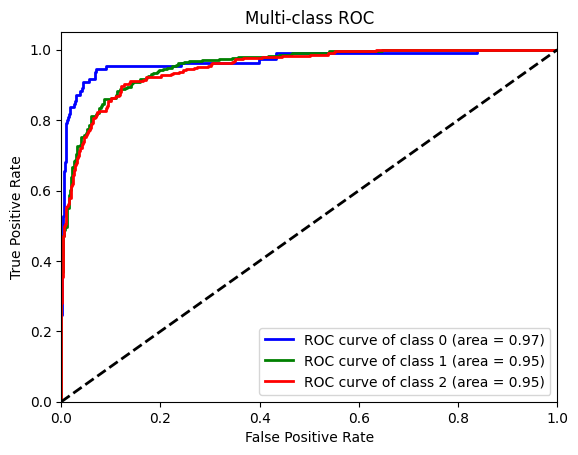

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the true labels if they aren't already
n_classes = 3  # Assuming 3 classes: negative, positive, neutral
true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.8701030927835052


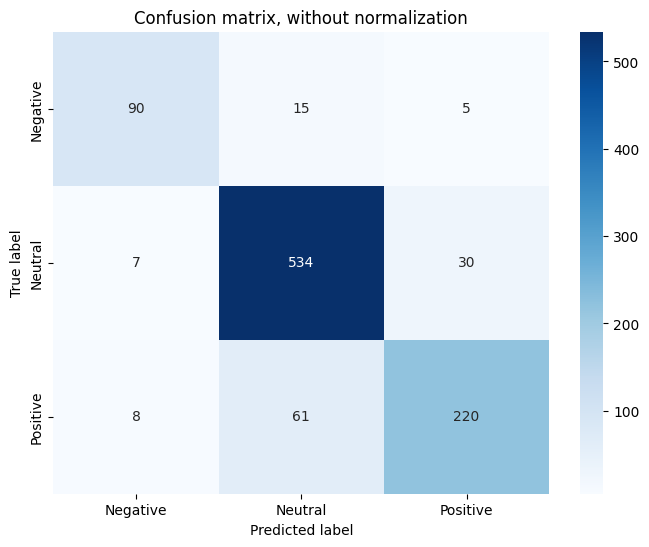

In [ ]:
# Calculate accuracy
if len(true_labels.shape) > 1 and true_labels.shape[1] > 1:  # Check if `true_labels` is one-hot encoded
    true_labels = np.argmax(true_labels, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Negative',  'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion matrix, without normalization')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Using Best Model to Find Sentiment of Congress Tweets

In [ ]:
import pandas as pd
import json
import os

# Initialize an empty list to hold all tweet data
tweets_data = []

# Set the directory where the JSON files are stored (adjust the path as necessary)
directory_path = 'congress_tweets'  # Replace with the actual path

# Loop through each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json'):  # Ensure processing only JSON files
        # Extract the date from the filename
        date = filename.split('.')[0]

        # Construct the full file path
        file_path = os.path.join(directory_path, filename)

        # Read the JSON file
        with open(file_path, 'r') as file:
            tweets = json.load(file)

        # Extract 'text' of each tweet and the date, and add to the list
        for tweet in tweets:
            try:
                tweet_data = {'Date': date, 'Text': tweet['text']}
            except KeyError:
                # Handle the absence of 'text'. For example, skip this tweet or use 'N/A' or any other placeholder
                tweet_data = {'Date': date, 'Text': 'N/A'}
                continue  # Skip this tweet

            tweets_data.append(tweet_data)

# Convert the list of dictionaries to a DataFrame
congressTweets_df = pd.DataFrame(tweets_data)

# Display the first few rows of the DataFrame to verify
print(congressTweets_df.head())


         Date                                               Text
0  2018-10-17  Just learned that I've received a score of 100...
1  2018-10-17  @Gatorkft @TMZLive https://www.merriam-webster...
2  2018-10-17  #WednesdayWisdom\n\nPalestinian Partnership Fu...
3  2018-10-17  A special story from the @AUG_Chronicle. Wishi...
4  2018-10-17  RT @FoxNews .@POTUS: I’m having a cabinet meet...


In [ ]:
import pandas as pd



congressTweets_df['Date'] = pd.to_datetime(congressTweets_df['Date'])

congressTweets_df = congressTweets_df.sort_values(by='Date')


print(congressTweets_df.head())


date_range = pd.date_range(start=congressTweets_df['Date'].min(), end=congressTweets_df['Date'].max())
print(date_range)
missing_dates = date_range.difference(congressTweets_df['Date'])

# Display missing dates
print("Missing Dates:")
print(missing_dates)


# # Define your start and end date for the filter
# start_date = '2020-02-01'
# end_date = '2022-12-22'

# Filter the DataFrame to only include rows within the date range
# congressTweets_df = congressTweets_df[(congressTweets_df['Date'] >= start_date) & (congressTweets_df['Date'] <= end_date)]


              Date                                               Text
2736056 2017-06-21  On #TheLongestDay, let's recommit to the fight...
2734242 2017-06-21  TY @mikedebonis @RepDianaDeGette @repgregwalde...
2734241 2017-06-21  This is a top priority for me and includes: Fi...
2734240 2017-06-21  Mean &amp; cold-hearted➡️ GOP plan to slash Me...
2734239 2017-06-21  Today, more sanctions targeting #Russian aggre...
DatetimeIndex(['2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
               '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30',
               ...
               '2023-07-02', '2023-07-03', '2023-07-04', '2023-07-05',
               '2023-07-06', '2023-07-07', '2023-07-08', '2023-07-09',
               '2023-07-10', '2023-07-11'],
              dtype='datetime64[ns]', length=2212, freq='D')
Missing Dates:
DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2022-01-15', '2022-03-17', 

In [ ]:
from transformers import BertTokenizer

# Tokenise all the texts and find the max length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length = 143
encoded_data = encode_data(tokenizer, congressTweets_df['Text'].values, max_length)

dataset = TensorDataset(
    encoded_data['input_ids'],
    encoded_data['attention_mask']
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

NameError: name 'TensorDataset' is not defined

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(
    encoded_data['input_ids'],
    encoded_data['attention_mask']
)

In [ ]:
print(encoded_data)


{'input_ids': tensor([[  101,  2006,  2723,  ...,     0,     0,     0],
        [  101,  3472,  1030,  ...,     0,     0,     0],
        [  101, 19387,  1030,  ...,     0,     0,     0],
        ...,
        [  101,  2307,  2000,  ...,     0,     0,     0],
        [  101, 19387,  1030,  ...,     0,     0,     0],
        [  101,  2006,  1996,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
import torch
torch.save(encoded_data, 'drive/MyDrive/encoded_data.pt')



In [ ]:

torch.cuda.empty_cache()




In [ ]:

import torch
from torch.utils.data import DataLoader, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

from transformers import BertForSequenceClassification, BertConfig
import torch

batch_size=64

dataloader_final = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

# Path to your saved model weights
model_path = 'drive/MyDrive/best_model_state2.bin'


config = BertConfig.from_pretrained('bert-base-uncased', num_labels=3)
bert_model = BertForSequenceClassification(config)

# Load the state dict from the file
bert_model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to the appropriate device and set it to evaluation mode
bert_model.to(device)
bert_model.eval()

bert_model.to(device) # Move model to the appropriate device

# Lists to hold predictions and true labels
sentiment = []

# Predict
with torch.no_grad():
    for batch in dataloader_final:
        batch = tuple(item.to(device) for item in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

        outputs = bert_model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

        sentiment.append(probs.cpu().numpy())

# Concatenate the results across the batches
sentiment = np.concatenate(sentiment, axis=0)



In [ ]:
print(sentiment)
congressTweets_df.head()


[[1.3309016e-03 9.3285745e-01 6.5811597e-02]
 [9.3544626e-01 6.1485942e-02 3.0677426e-03]
 [7.1276317e-04 9.8780072e-01 1.1486505e-02]
 ...
 [3.9948730e-04 9.9480385e-01 4.7966442e-03]
 [4.5273108e-03 5.6495279e-01 4.3051991e-01]
 [5.5366144e-02 9.3822080e-01 6.4129848e-03]]


In [ ]:
sentiment_df = pd.DataFrame(sentiment, columns=['Negative', 'Neutral', 'Positive'])

congressTweets_df = pd.concat([congressTweets_df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)
congressTweets_df.head()


,Date,Text,Negative,Neutral,Positive
0,2017-06-21,On Floor to recognize National #PollinatorWeek...,0.001331,0.932857,0.065812
1,2017-06-21,Chairman @senorrinhatch says #Obamacare is 'po...,0.935446,0.061486,0.003068
2,2017-06-21,"RT @JPMajor NASA's Opportunity rover, now in i...",0.000713,0.987801,0.011487
3,2017-06-21,Just awful. Child fatality numbers related to ...,0.706506,0.214995,0.078499
4,2017-06-21,Proud to help introduce this bipartisan bill. ...,0.002158,0.713268,0.284574


In [ ]:
print(len(congressTweets_df))

5068351


# Using Best Model to Find Sentiment of S&P500 News

In [ ]:
congressTweets_df.to_csv('drive/MyDrive/twitter_sentimentBERT2.csv')

In [ ]:
import pandas as pd

news_df = pd.read_csv('sp500_news_290k_articles.csv')

news_df.rename(columns={'headline': 'Text', 'date': 'Date'}, inplace=True)

import pandas as pd


# Define a custom function to handle multiple date formats
def custom_date_parser(date_str):
    formats = ['%b-%d-%y', '%Y-%m-%dT%H:%M:%S.%fZ']

    # Try each format
    for fmt in formats:
        try:
            # Return the first successful conversion
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            # If ValueError is raised, try the next format
            pass

    # If none of the formats work, return NaT
    return pd.NaT

# Apply the custom parser to each date in the column
news_df['Date'] = news_df['Date'].apply(custom_date_parser)

# Verify the operation by checking the data type again
print(news_df['Date'].dtype)





datetime64[ns]


In [ ]:
print(news_df[news_df['Date'].isna()])
print(len(news_df))

Empty DataFrame
Columns: [_id, compound, Date, Text, neg, neu, pos, ticker, time]
Index: []
290728


In [ ]:
import pandas as pd

# Find the date range
date_range_start = news_df['Date'].min()
date_range_end = news_df['Date'].max()

print(f"Date range starts from {date_range_start} to {date_range_end}.")

# Generate a date range that covers all dates within the found range
all_dates = pd.date_range(start=date_range_start, end=date_range_end, freq='D')



print(len(news_df))
# Identify missing dates by comparing the generated range with the existing dates
missing_dates = all_dates.difference(news_df['Date'])

print(f"Missing dates are: {missing_dates}")
print(len(missing_dates))


Date range starts from 2019-12-19 00:00:00 to 2023-03-04 00:00:00.
290728
Missing dates are: DatetimeIndex(['2019-12-20', '2019-12-21', '2019-12-22', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-28', '2019-12-29',
               ...
               '2020-10-31', '2020-11-07', '2020-11-08', '2020-11-15',
               '2020-11-22', '2020-12-26', '2020-12-27', '2021-01-02',
               '2021-01-16', '2021-07-04'],
              dtype='datetime64[ns]', length=217, freq=None)
217


Date range starts from 2019-12-19 00:00:00 to 2023-03-04 00:00:00.


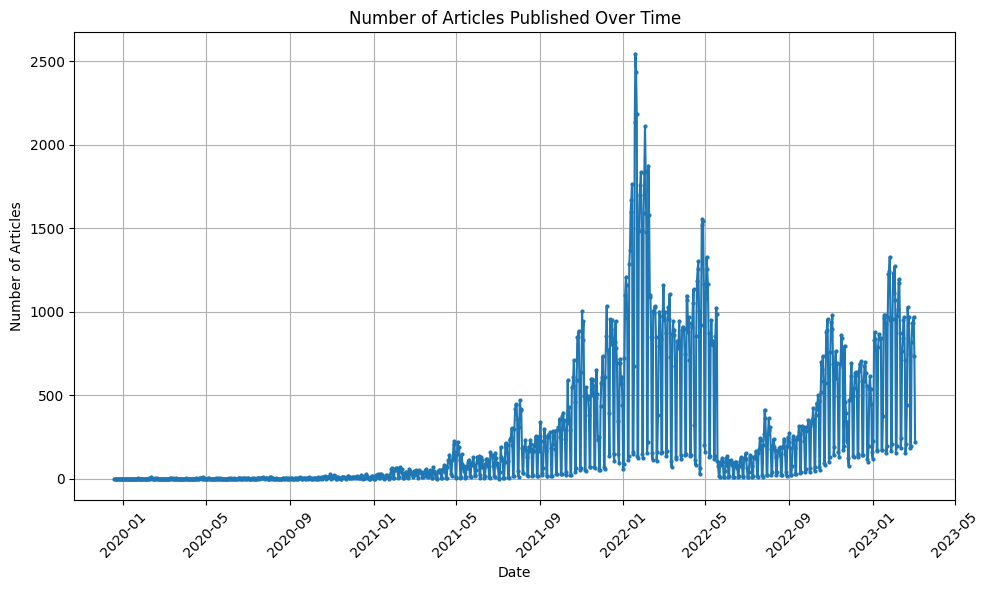

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



print(f"Date range starts from {date_range_start} to {date_range_end}.")

# Count the number of articles per day
articles_per_day = news_df.groupby(news_df['Date'].dt.date).size()


all_dates = pd.date_range(start=date_range_start, end=date_range_end, freq='D')

all_dates_df = pd.DataFrame(index=all_dates)
all_dates_df.index.name = 'Date'

all_dates_df.index = pd.to_datetime(all_dates_df.index)

articles_per_day_df = pd.merge(all_dates_df, articles_per_day.rename('ArticleCount'), how='left', left_index=True, right_index=True).fillna(0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(articles_per_day_df.index, articles_per_day_df['ArticleCount'], marker='o', linestyle='-', markersize=2)
plt.title('Number of Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()



plt.show()


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenise all the texts and find the max length
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length = 143
encoded_data = encode_data(tokenizer, news_df['Text'].values, max_length)

dataset = TensorDataset(
    encoded_data['input_ids'],
    encoded_data['attention_mask']
)


In [ ]:

import torch
from torch.utils.data import DataLoader, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

from transformers import BertForSequenceClassification, BertConfig
import torch

batch_size=64

dataloader_final = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

# Path to your saved model weights
model_path = 'drive/MyDrive/best_model_state2.bin'


config = BertConfig.from_pretrained('bert-base-uncased', num_labels=3)  # Adjust as needed
bert_model = BertForSequenceClassification(config)

# Load the state dict from the file
bert_model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to the appropriate device and set it to evaluation mode
bert_model.to(device)
bert_model.eval()

bert_model.to(device) # Move model to the appropriate device

# Lists to hold predictions and true labels
sentiment = []

# Predict
with torch.no_grad():
    for batch in dataloader_final:
        batch = tuple(item.to(device) for item in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

        outputs = bert_model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

        sentiment.append(probs.cpu().numpy())

# Concatenate the results across the batches
sentiment = np.concatenate(sentiment, axis=0)



In [ ]:

sentiment_df = pd.DataFrame(sentiment, columns=['Negative', 'Neutral', 'Positive'])


news_df = pd.concat([news_df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)
print(news_df.head())


                        _id  compound       Date  \
0  61ec1c1ad68efb091ce207ce    0.2960 2022-01-09   
1  61ec1c1ad68efb091ce207ca    0.3612 2022-01-21   
2  61ec1c1bd68efb091ce207ec    0.0000 2021-11-18   
3  61ec1c1bd68efb091ce207ef    0.0000 2021-11-16   
4  61ec1c1dd68efb091ce2080d   -0.3182 2021-10-13   

                                                Text    neg    neu    pos  \
0  What Type Of Shareholders Make Up Agilent Tech...  0.000  0.833  0.167   
1  Asset Dedication, LLC Buys Invesco BulletShare...  0.000  0.828  0.172   
2  Agilent (A) to Report Q4 Earnings: What's in t...  0.000  1.000  0.000   
3  Alibaba (BABA) to Report Q2 Earnings: What's i...  0.000  1.000  0.000   
4  Agilent Receives FDA Companion Diagnostic Appr...  0.205  0.651  0.144   

  ticker     time  Negative   Neutral  Positive  
0      A  06:06AM  0.000419  0.998965  0.000616  
1      A  09:38AM  0.000261  0.998798  0.000941  
2      A  09:02AM  0.000420  0.998644  0.000936  
3      A  10:23AM  0.000

In [ ]:
news_df.to_csv('drive/MyDrive/sp500_newsBERT2.csv')

# Integrating sentiment using LM Financial Dictionary

Sentiment Dictionaries

In [ ]:
!unzip drive/MyDrive/Colab\ Notebooks/congress_tweets

Archive:  drive/MyDrive/Colab Notebooks/congress_tweets.zip
   creating: congress_tweets/
  inflating: __MACOSX/._congress_tweets  
  inflating: congress_tweets/2019-11-21.json  
  inflating: __MACOSX/congress_tweets/._2019-11-21.json  
  inflating: congress_tweets/2022-04-11.json  
  inflating: __MACOSX/congress_tweets/._2022-04-11.json  
  inflating: congress_tweets/2020-11-18.json  
  inflating: __MACOSX/congress_tweets/._2020-11-18.json  
  inflating: congress_tweets/2019-01-21.json  
  inflating: __MACOSX/congress_tweets/._2019-01-21.json  
  inflating: congress_tweets/2020-01-18.json  
  inflating: __MACOSX/congress_tweets/._2020-01-18.json  
  inflating: congress_tweets/2020-03-25.json  
  inflating: __MACOSX/congress_tweets/._2020-03-25.json  
  inflating: congress_tweets/2018-09-05.json  
  inflating: __MACOSX/congress_tweets/._2018-09-05.json  
  inflating: congress_tweets/2017-11-18.json  
  inflating: __MACOSX/congress_tweets/._2017-11-18.json  
  inflating: congress_tweets

In [ ]:
import pandas as pd
import json
import os

# Initialize an empty list to hold all tweet data
tweets_data = []

# Set the directory where the JSON files are stored (adjust the path as necessary)
directory_path = 'congress_tweets'  # Replace with the actual path

# Loop through each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json'):  # Ensure processing only JSON files
        # Extract the date from the filename
        date = filename.split('.')[0]

        # Construct the full file path
        file_path = os.path.join(directory_path, filename)

        # Read the JSON file
        with open(file_path, 'r') as file:
            tweets = json.load(file)

        # Extract 'text' of each tweet and the date, and add to the list
        for tweet in tweets:
            try:
                tweet_data = {'Date': date, 'Text': tweet['text']}
            except KeyError:
                # Handle the absence of 'text'. For example, skip this tweet or use 'N/A' or any other placeholder
                # Uncomment the line below to use 'N/A' as a placeholder
                tweet_data = {'Date': date, 'Text': 'N/A'}
                continue  # Skip this tweet

            tweets_data.append(tweet_data)

# Convert the list of dictionaries to a DataFrame
congressTweets_df = pd.DataFrame(tweets_data)

# Display the first few rows of the DataFrame to verify
print(congressTweets_df.head())


         Date                                               Text
0  2021-09-27  Blackburn, Hagerty want to expand 'Save our St...
1  2021-09-27  I have a 52 year old friend with #DownsSyndrom...
2  2021-09-27  RT @danhill2011 George W. Bush has declared "W...
3  2021-09-27  RT @laralogan They forgot to include their pup...
4  2021-09-27  RT @laurenboebert Two-year-olds are getting fo...


In [ ]:
# Filter the DataFrame to display only the rows where 'text' is 'N/A'
na_text_df = congressTweets_df[congressTweets_df['Text'] == 'N/A']

# Display the filtered DataFrame
print(na_text_df)


Empty DataFrame
Columns: [Date, Text]
Index: []


In [ ]:
import pandas as pd


# Step 1: Convert the 'date' column to datetime format
congressTweets_df['Date'] = pd.to_datetime(congressTweets_df['Date'])

congressTweets_df = congressTweets_df.sort_values(by='Date')

# Display the sorted DataFrame to verify the order
print(congressTweets_df.head())

# Step 2: Generate a date range from the minimum to the maximum date in your dataset
date_range = pd.date_range(start=congressTweets_df['Date'].min(), end=congressTweets_df['Date'].max())

# Step 3: Identify missing dates by comparing the generated date range with the dates present in your dataset
missing_dates = date_range.difference(congressTweets_df['Date'])

# Display missing dates
print("Missing Dates:")
print(missing_dates)


# # Define your start and end date for the filter
# start_date = '2020-02-01'
# end_date = '2022-12-22'

# # Filter the DataFrame to only include rows within the date range
# congressTweets_df = congressTweets_df[(congressTweets_df['Date'] >= start_date) & (congressTweets_df['Date'] <= end_date)]


              Date                                               Text
3289289 2017-06-21  We have begun 10 minutes of debate on the Rep....
3289693 2017-06-21  The Obamacare status quo: After pulling out of...
3289692 2017-06-21  Headed to floor to discuss why we must push ba...
3289691 2017-06-21  .@realDonaldTrump, you said you wanted to work...
3289690 2017-06-21  Joined @RepJeffries &amp; @RepGraceMeng to che...
Missing Dates:
DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2022-01-15', '2022-03-17', '2022-03-26', '2022-10-24',
               '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28',
               '2022-10-29', '2022-10-30', '2022-10-31'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
!pip install pysentiment2
import pandas as pd
import numpy as np
import re
import nltk
import html
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
import pysentiment2 as ps
tokeniser = ps.LM()
# Preprocessing function
def preprocess_tweets(df):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    # Hashtag and hyperlink removal
    # Hashtag, mention, and hyperlink removal
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'@\w+|#\w+|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', str(x)))

    # Unescape HTML entities (e.g., &amp; -> &)
    df['Text'] = df['Text'].apply(lambda x: html.unescape(str(x)))

    # Punctuation and emoji removal and lowercasing
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))
    df['Text'] = df['Text'].apply(lambda x: x.lower())

    # # Tokenization
    # df['Text'] = df['Text'].apply(lambda x: nltk.word_tokenize(str(x)))
    df['Text'] = df['Text'].apply(tokeniser.tokenize)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in stop_words])

    # # Lemmatization
    # lemmatizer = WordNetLemmatizer()
    # df['Text'] = df['Text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return df


In [ ]:
congressTweets_df = preprocess_tweets(congressTweets_df.copy())
congressTweets_df['score'] = congressTweets_df['Text'].apply(tokeniser.get_score)
congressTweets_df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Date,Text,score
3289289,2017-06-21,"[begun, minut, debat, rep, dca, amend]","{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."
3289693,2017-06-21,"[obamacar, statu, quo, pull, flee, exchang]","{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."
3289692,2017-06-21,"[floor, discuss, push, rier, benefit, stay, tune]","{'Positive': 1, 'Negative': 0, 'Polarity': 0.9..."
3289691,2017-06-21,"[said, want, work, reduc, took, wordther, time...","{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."
3289690,2017-06-21,"[join, cheer, colleagu]","{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."


In [ ]:
congressTweets_df.to_csv('drive/MyDrive/twitter_sentimentLM2')

In [ ]:
import pandas as pd

news_df = pd.read_csv('sp500_news_290k_articles.csv')

news_df.rename(columns={'headline': 'Text', 'date': 'Date'}, inplace=True)

import pandas as pd


# Define a custom function to handle multiple date formats
def custom_date_parser(date_str):
    formats = ['%b-%d-%y', '%Y-%m-%dT%H:%M:%S.%fZ']

    # Try each format
    for fmt in formats:
        try:
            # Return the first successful conversion
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            # If ValueError is raised, try the next format
            pass

    # If none of the formats work, return NaT
    return pd.NaT

# Apply the custom parser to each date in the column
news_df['Date'] = news_df['Date'].apply(custom_date_parser)

# Verify the operation by checking the data type again
print(news_df['Date'].dtype)





datetime64[ns]


In [ ]:
print(news_df[news_df['Date'].isna()])
print(len(news_df))

Empty DataFrame
Columns: [_id, compound, Date, Text, neg, neu, pos, ticker, time]
Index: []
290728


In [ ]:
!pip install pysentiment2
import pandas as pd
import numpy as np
import re
import nltk
import html
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
import pysentiment2 as ps
tokeniser = ps.LM()
# Preprocessing function
def preprocess_tweets(df):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    # Hashtag and hyperlink removal
    # Hashtag, mention, and hyperlink removal
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'@\w+|#\w+|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', str(x)))

    # Unescape HTML entities (e.g., &amp; -> &)
    df['Text'] = df['Text'].apply(lambda x: html.unescape(str(x)))

    # Punctuation and emoji removal and lowercasing
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))
    df['Text'] = df['Text'].apply(lambda x: x.lower())

    # # Tokenization
    # df['Text'] = df['Text'].apply(lambda x: nltk.word_tokenize(str(x)))
    df['Text'] = df['Text'].apply(tokeniser.tokenize)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in stop_words])

    # # Lemmatization
    # lemmatizer = WordNetLemmatizer()
    # df['Text'] = df['Text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return df


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00


In [ ]:
news_df = preprocess_tweets(news_df.copy())
news_df['score'] = news_df['Text'].apply(tokeniser.get_score)
news_df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,_id,compound,Date,Text,neg,neu,pos,ticker,time,score
0,61ec1c1ad68efb091ce207ce,0.2960,2022-01-09,"[type, sharehold, make, agil, technolog, nysea...",0.000,0.833,0.167,A,06:06AM,"{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."
1,61ec1c1ad68efb091ce207ca,0.3612,2022-01-21,"[asset, dedic, llc, buy, invesco, bulletshar, ...",0.000,0.828,0.172,A,09:38AM,"{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."
2,61ec1c1bd68efb091ce207ec,0.0000,2021-11-18,"[agil, report, q, earn]",0.000,1.000,0.000,A,09:02AM,"{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."
3,61ec1c1bd68efb091ce207ef,0.0000,2021-11-16,"[alibaba, baba, report, q, earn]",0.000,1.000,0.000,A,10:23AM,"{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."
4,61ec1c1dd68efb091ce2080d,-0.3182,2021-10-13,"[agil, receiv, fda, companion, diagnost, appro...",0.205,0.651,0.144,A,04:16PM,"{'Positive': 0, 'Negative': 0, 'Polarity': 0.0..."


In [ ]:
news_df.to_csv('drive/MyDrive/sp500_newsLM2.csv')